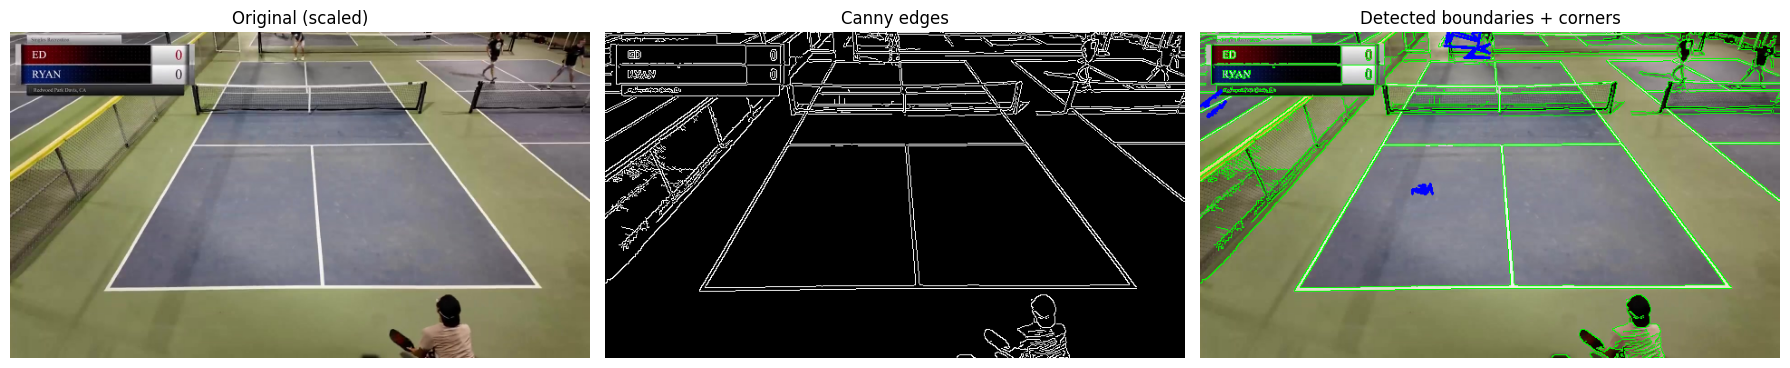

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "./img_0005.jpg"
orig = cv2.imread(img_path)
if orig is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

# Resize for display purposes (optional)
scale = 0.5
h, w = orig.shape[:2]
disp = cv2.resize(orig, (int(w*scale), int(h*scale)))

# 1) Canny edge detection
gray = cv2.cvtColor(disp, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# 2) Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# 3) Filter long contours and approximate
long_contours = [cnt for cnt in contours if cv2.arcLength(cnt, False) > 200]
polylines = []
for cnt in long_contours:
    eps = 0.01 * cv2.arcLength(cnt, False)
    poly = cv2.approxPolyDP(cnt, eps, False)
    polylines.append(poly.reshape(-1,2))

# 4) Pick top4 by length
polylines.sort(key=lambda pts: len(pts), reverse=True)
top4 = polylines[:4]

# 5) Collect endpoints for clustering
pts = np.vstack([np.vstack((line[0], line[-1])) for line in top4]).astype(np.float32)

# 6) KMeans clustering into 4 corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
_, labels, centers = cv2.kmeans(pts, 4, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

# 7) Visualize results
annot = disp.copy()
# Draw edges
annot[edges>0] = [0, 255, 0]  # highlight edges in green
# Draw approximate polylines
for line in top4:
    pts_line = (line * np.array([scale, scale])).astype(int)
    cv2.polylines(annot, [pts_line], False, (255, 0, 0), 2)

# Draw cluster centers
for c in centers:
    x, y = c
    cv2.circle(annot, (int(x), int(y)), 8, (0,0,255), -1)
    cv2.putText(annot, f"({int(x)},{int(y)})", (int(x)+5, int(y)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

# Show original, edges, and annotated
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original (scaled)")
axes[0].axis("off")

axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Canny edges")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))
axes[2].set_title("Detected boundaries + corners")
axes[2].axis("off")

plt.tight_layout()
plt.show()
